In [1]:
import pyslha #For interacting with SLHA files
import subprocess #Running command
import scipy #Numeric Library
import sympy #symbolic computation - might not be used here
from scipy import optimize
from sympy import *
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
%matplotlib inline
from numpy import logspace, linspace 
from itertools import product
import glob #filehandling
from subprocess import call
import os
#Path to modified verison of Softsusy 
SoftSUSY_PATH = 'softsusy-4.1.4-Garon/softpoint.x' 
mHiggs = 125 #Higgs Mass for paper
print ("hello")

hello


In [60]:
def slhaPoint(model='FGMCaseB0', mMess=1e12, tanBeta=10, beta2=0, beta3=0, betaeps=0.0, thetavev=0, 
              outputFile='test.slha', Lambda=1e6, mode='point', LambdaGuess=2e6):
    '''
    Code for interacting with SoftSUSY and running the models we've been looking at.
    The models themselves are encoded in a modified version of it. 
    This may seem like extra work because it accepts an arbitrary SLHA2 file, but since our models
    include fitted parameters, like the Yukawa couplings, we need to use the values that it calculates
    during the running. 
    The parameters:
    model - the name of the model in SoftSUSY
    mMess - the messenger scale
    tanBeta - tan beta
    beta2 - beta2
    beta3 - beta3
    outputFile - the name of the file to write to (this step could conceivably be removed by writing the console output to memory)
    Lambda - F/M
    mode - There are 3 modes
        'Fit' - uses Newton's method from a few different starting points
        'Bisect' - uses a Bisection routine from a few different brackets
        'Point' - runs a single point
    LambdaGuess - a guess at the value of Lambda for the 'Fit' mode.
    '''
    
    dataline ="./{} {} --mMess={} --LAMBDA={} --tanBeta={} --beta2={} --beta3={} --thetavev={} --betaeps={} --cgrav=1. > {}"
    startingPoints = [LambdaGuess, 1e6, 5e6, 6e4]
    bracket, l = [(2,5), (5,10), (2,10), (2,8), (4,8), (1,3), (8,12)], 0
    
    #a helper functin that takes a value of x (Lambda), runs it (line 2) and then reads in the Higgs mass
    def f(x):
        string = dataline.format(SoftSUSY_PATH, model, str(mMess), str(x), 
                                 str(tanBeta), str(beta2), str(beta3), str(thetavev), str(betaeps), outputFile)
        subprocess.Popen(string, stdout=None, shell=True).wait()
        #print ("the string is ")
        print (string)
        return pyslha.read(outputFile).blocks['MASS'][25] - mHiggs
    
    if mode == 'Fit':
        #print ('in fit')
        a, i = 0, 0
        while((a <= 0) & (i < len(startingPoints))):
            try:
                #Newton's method
                print ("in try")
                a = optimize.newton(f, startingPoints[i], tol=1e-4)
                print ("in newton")
                print (a)
            except:
                print ('got excepted')
                a = 0
                i += 1
        if (a>0):
            data = pyslha.read(outputFile)
            #accept or reject based on the deviation from the Higgs mass
            if (-0.1 < data.blocks['MASS'][25]-125 < 0.1) :
                try:
                    #if there's something in this location SoftSUSY has an error.
                    data.blocks['SPINFO'][3]
                except:
                    return data
    elif mode == 'Bisect':
        for k in bracket:
            print(k)
            try:
                l = optimize.brentq(f, k[0] * 1e5, k[1] * 1e5, rtol=1e-4)
                if l:
                    break
            except:
                #print('nada')
                continue
        if l:
            data = pyslha.read(outputFile)
            print(data.blocks['MASS'][25])
            if (-0.25 < data.blocks['MASS'][25]-125 < 0.25) :
                try:
                    data.blocks['SPINFO'][3]
                except:
                    return data
            else:
                #the bisection routine tends to get things close but not exact, so it calls 'Fit' if it's close.
                return slhaPoint(model, mMess, tanBeta, beta2, beta3,\
                              outputFile, Lambda, 'Fit', LambdaGuess=data.blocks['MINPAR'][1])
        else:
            #just to be safe (but is probably unneded)
            return slhaPoint(model, mMess, tanBeta, beta2, beta3,\
                              outputFile, Lambda, 'Fit')
    else:
        #runs a single point
        try:
            f(Lambda)
            data = pyslha.read(outputFile)
            return data.blocks['MASS'][25], data
        except (pyslha.ParseError, RuntimeError):
            return "No Solution", 0

In [59]:
gridmMess = logspace(6,16,41)
gridtabB = linspace(5,60,41)

resultsb2mMessVstanB = {}
for j in product(gridmMess, gridtabB):

    resultsb2mMessVstanB[j] = slhaPoint(model='FGMCaseB2', mMess=j[0], tanBeta=j[1],mode='Point')
    

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000.0 --LAMBDA=1000000.0 --tanBeta=5.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000.0 --LAMBDA=1000000.0 --tanBeta=6.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000.0 --LAMBDA=1000000.0 --tanBeta=7.75 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000.0 --LAMBDA=1000000.0 --tanBeta=9.125 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000.0 --LAMBDA=1000000.0 --tanBeta=10.5 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000.0 --LAMBDA=1000000.0 --tanBeta=11.875 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279.410038923 --LAMBDA=1000000.0 --tanBeta=16.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279.410038923 --LAMBDA=1000000.0 --tanBeta=17.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279.410038923 --LAMBDA=1000000.0 --tanBeta=18.75 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279.410038923 --LAMBDA=1000000.0 --tanBeta=20.125 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279.410038923 --LAMBDA=1000000.0 --tanBeta=21.5 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279.410038923 --LAMBDA=1000000.0 --tanBeta=22.875 --beta2=0 --b

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277.6601683795 --LAMBDA=1000000.0 --tanBeta=25.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277.6601683795 --LAMBDA=1000000.0 --tanBeta=27.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277.6601683795 --LAMBDA=1000000.0 --tanBeta=28.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277.6601683795 --LAMBDA=1000000.0 --tanBeta=29.75 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277.6601683795 --LAMBDA=1000000.0 --tanBeta=31.125 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277.6601683795 --LAMBDA=1000000.0 --tanBeta=32.5 --beta2

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413.251903491 --LAMBDA=1000000.0 --tanBeta=35.25 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413.251903491 --LAMBDA=1000000.0 --tanBeta=36.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413.251903491 --LAMBDA=1000000.0 --tanBeta=38.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413.251903491 --LAMBDA=1000000.0 --tanBeta=39.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413.251903491 --LAMBDA=1000000.0 --tanBeta=40.75 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413.251903491 --LAMBDA=1000000.0 --tanBeta=42.125 --beta2=0 --

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000.0 --LAMBDA=1000000.0 --tanBeta=44.875 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000.0 --LAMBDA=1000000.0 --tanBeta=46.25 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000.0 --LAMBDA=1000000.0 --tanBeta=47.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000.0 --LAMBDA=1000000.0 --tanBeta=49.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000.0 --LAMBDA=1000000.0 --tanBeta=50.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000.0 --LAMBDA=1000000.0 --tanBeta=51.75 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794.100389227 --LAMBDA=1000000.0 --tanBeta=53.125 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794.100389227 --LAMBDA=1000000.0 --tanBeta=54.5 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794.100389227 --LAMBDA=1000000.0 --tanBeta=55.875 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794.100389227 --LAMBDA=1000000.0 --tanBeta=57.25 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794.100389227 --LAMBDA=1000000.0 --tanBeta=58.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794.100389227 --LAMBDA=1000000.0 --tanBeta=60.0 --beta2

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132.51903491 --LAMBDA=1000000.0 --tanBeta=5.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132.51903491 --LAMBDA=1000000.0 --tanBeta=6.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132.51903491 --LAMBDA=1000000.0 --tanBeta=7.75 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132.51903491 --LAMBDA=1000000.0 --tanBeta=9.125 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132.51903491 --LAMBDA=1000000.0 --tanBeta=10.5 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132.51903491 --LAMBDA=1000000.0 --tanBeta=11.875 --beta2=0 --beta3

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000.0 --LAMBDA=1000000.0 --tanBeta=14.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000.0 --LAMBDA=1000000.0 --tanBeta=16.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000.0 --LAMBDA=1000000.0 --tanBeta=17.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000.0 --LAMBDA=1000000.0 --tanBeta=18.75 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000.0 --LAMBDA=1000000.0 --tanBeta=20.125 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000.0 --LAMBDA=1000000.0 --tanBeta=21.5 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941.00389227 --LAMBDA=1000000.0 --tanBeta=25.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941.00389227 --LAMBDA=1000000.0 --tanBeta=27.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941.00389227 --LAMBDA=1000000.0 --tanBeta=28.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941.00389227 --LAMBDA=1000000.0 --tanBeta=29.75 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941.00389227 --LAMBDA=1000000.0 --tanBeta=31.125 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941.00389227 --LAMBDA=1000000.0 --tanBeta=32.5 --beta2

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766.01683795 --LAMBDA=1000000.0 --tanBeta=33.875 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766.01683795 --LAMBDA=1000000.0 --tanBeta=35.25 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766.01683795 --LAMBDA=1000000.0 --tanBeta=36.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766.01683795 --LAMBDA=1000000.0 --tanBeta=38.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766.01683795 --LAMBDA=1000000.0 --tanBeta=39.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766.01683795 --LAMBDA=1000000.0 --tanBeta=40.75 --beta

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325.1903491 --LAMBDA=1000000.0 --tanBeta=42.125 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325.1903491 --LAMBDA=1000000.0 --tanBeta=43.5 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325.1903491 --LAMBDA=1000000.0 --tanBeta=44.875 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325.1903491 --LAMBDA=1000000.0 --tanBeta=46.25 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325.1903491 --LAMBDA=1000000.0 --tanBeta=47.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325.1903491 --LAMBDA=1000000.0 --tanBeta=49.0 --beta2=0 --b

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000.0 --LAMBDA=1000000.0 --tanBeta=53.125 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000.0 --LAMBDA=1000000.0 --tanBeta=54.5 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000.0 --LAMBDA=1000000.0 --tanBeta=55.875 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000.0 --LAMBDA=1000000.0 --tanBeta=57.25 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000.0 --LAMBDA=1000000.0 --tanBeta=58.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000.0 --LAMBDA=1000000.0 --tanBeta=60.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660.1683793 --LAMBDA=1000000.0 --tanBeta=6.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660.1683793 --LAMBDA=1000000.0 --tanBeta=7.75 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660.1683793 --LAMBDA=1000000.0 --tanBeta=9.125 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660.1683793 --LAMBDA=1000000.0 --tanBeta=10.5 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660.1683793 --LAMBDA=1000000.0 --tanBeta=11.875 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660.1683793 --LAMBDA=1000000.0 --tanBeta=13.25 --beta2=0

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251.903491 --LAMBDA=1000000.0 --tanBeta=14.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251.903491 --LAMBDA=1000000.0 --tanBeta=16.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251.903491 --LAMBDA=1000000.0 --tanBeta=17.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251.903491 --LAMBDA=1000000.0 --tanBeta=18.75 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251.903491 --LAMBDA=1000000.0 --tanBeta=20.125 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251.903491 --LAMBDA=1000000.0 --tanBeta=21.5 --beta2=0 --b

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000000.0 --LAMBDA=1000000.0 --tanBeta=24.25 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000000.0 --LAMBDA=1000000.0 --tanBeta=25.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000000.0 --LAMBDA=1000000.0 --tanBeta=27.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000000.0 --LAMBDA=1000000.0 --tanBeta=28.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000000.0 --LAMBDA=1000000.0 --tanBeta=29.75 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000000.0 --LAMBDA=1000000.0 --tanBeta=31.125 --beta2=0 --beta3=0 --thetavev=0 --b

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100.38923 --LAMBDA=1000000.0 --tanBeta=35.25 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100.38923 --LAMBDA=1000000.0 --tanBeta=36.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100.38923 --LAMBDA=1000000.0 --tanBeta=38.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100.38923 --LAMBDA=1000000.0 --tanBeta=39.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100.38923 --LAMBDA=1000000.0 --tanBeta=40.75 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100.38923 --LAMBDA=1000000.0 --tanBeta=42.125 --beta2=0 --

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601.683792 --LAMBDA=1000000.0 --tanBeta=44.875 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601.683792 --LAMBDA=1000000.0 --tanBeta=46.25 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601.683792 --LAMBDA=1000000.0 --tanBeta=47.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601.683792 --LAMBDA=1000000.0 --tanBeta=49.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601.683792 --LAMBDA=1000000.0 --tanBeta=50.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601.683792 --LAMBDA=1000000.0 --tanBeta=51.75 --beta

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519.034904 --LAMBDA=1000000.0 --tanBeta=53.125 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519.034904 --LAMBDA=1000000.0 --tanBeta=54.5 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519.034904 --LAMBDA=1000000.0 --tanBeta=55.875 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519.034904 --LAMBDA=1000000.0 --tanBeta=57.25 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519.034904 --LAMBDA=1000000.0 --tanBeta=58.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519.034904 --LAMBDA=1000000.0 --tanBeta=60.0 --beta2

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941003.89227 --LAMBDA=1000000.0 --tanBeta=7.75 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941003.89227 --LAMBDA=1000000.0 --tanBeta=9.125 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941003.89227 --LAMBDA=1000000.0 --tanBeta=10.5 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941003.89227 --LAMBDA=1000000.0 --tanBeta=11.875 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941003.89227 --LAMBDA=1000000.0 --tanBeta=13.25 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941003.89227 --LAMBDA=1000000.0 --tanBeta=14.625 --beta2=

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766016.83795 --LAMBDA=1000000.0 --tanBeta=16.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766016.83795 --LAMBDA=1000000.0 --tanBeta=17.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766016.83795 --LAMBDA=1000000.0 --tanBeta=18.75 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766016.83795 --LAMBDA=1000000.0 --tanBeta=20.125 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766016.83795 --LAMBDA=1000000.0 --tanBeta=21.5 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766016.83795 --LAMBDA=1000000.0 --tanBeta=22.875 --beta2

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325190.3491 --LAMBDA=1000000.0 --tanBeta=25.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325190.3491 --LAMBDA=1000000.0 --tanBeta=27.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325190.3491 --LAMBDA=1000000.0 --tanBeta=28.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325190.3491 --LAMBDA=1000000.0 --tanBeta=29.75 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325190.3491 --LAMBDA=1000000.0 --tanBeta=31.125 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325190.3491 --LAMBDA=1000000.0 --tanBeta=32.5 --beta2=0 --b

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000000.0 --LAMBDA=1000000.0 --tanBeta=35.25 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000000.0 --LAMBDA=1000000.0 --tanBeta=36.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000000.0 --LAMBDA=1000000.0 --tanBeta=38.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000000.0 --LAMBDA=1000000.0 --tanBeta=39.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000000.0 --LAMBDA=1000000.0 --tanBeta=40.75 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000000.0 --LAMBDA=1000000.0 --tanBeta=42.125 --beta2=0 --beta3=0 --th

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410038.9229 --LAMBDA=1000000.0 --tanBeta=43.5 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410038.9229 --LAMBDA=1000000.0 --tanBeta=44.875 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410038.9229 --LAMBDA=1000000.0 --tanBeta=46.25 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410038.9229 --LAMBDA=1000000.0 --tanBeta=47.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410038.9229 --LAMBDA=1000000.0 --tanBeta=49.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410038.9229 --LAMBDA=1000000.0 --tanBeta=50.375 --beta2

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168.3794 --LAMBDA=1000000.0 --tanBeta=53.125 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168.3794 --LAMBDA=1000000.0 --tanBeta=54.5 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168.3794 --LAMBDA=1000000.0 --tanBeta=55.875 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168.3794 --LAMBDA=1000000.0 --tanBeta=57.25 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168.3794 --LAMBDA=1000000.0 --tanBeta=58.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168.3794 --LAMBDA=1000000.0 --tanBeta=60.0 --beta2

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000000000.0 --LAMBDA=1000000.0 --tanBeta=5.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000000000.0 --LAMBDA=1000000.0 --tanBeta=6.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000000000.0 --LAMBDA=1000000.0 --tanBeta=7.75 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000000000.0 --LAMBDA=1000000.0 --tanBeta=9.125 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000000000.0 --LAMBDA=1000000.0 --tanBeta=10.5 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000000000.0 --LAMBDA=1000000.0 --tanBeta=11.875 --beta2=0 --beta3=0 --t

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100389.227 --LAMBDA=1000000.0 --tanBeta=13.25 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100389.227 --LAMBDA=1000000.0 --tanBeta=14.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100389.227 --LAMBDA=1000000.0 --tanBeta=16.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100389.227 --LAMBDA=1000000.0 --tanBeta=17.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100389.227 --LAMBDA=1000000.0 --tanBeta=18.75 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100389.227 --LAMBDA=1000000.0 --tanBeta=20.125 --beta

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601683.793 --LAMBDA=1000000.0 --tanBeta=22.875 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601683.793 --LAMBDA=1000000.0 --tanBeta=24.25 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601683.793 --LAMBDA=1000000.0 --tanBeta=25.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601683.793 --LAMBDA=1000000.0 --tanBeta=27.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601683.793 --LAMBDA=1000000.0 --tanBeta=28.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601683.793 --LAMBDA=1000000.0 --tanBeta=29.75 --beta

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519034.91 --LAMBDA=1000000.0 --tanBeta=31.125 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519034.91 --LAMBDA=1000000.0 --tanBeta=32.5 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519034.91 --LAMBDA=1000000.0 --tanBeta=33.875 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519034.91 --LAMBDA=1000000.0 --tanBeta=35.25 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519034.91 --LAMBDA=1000000.0 --tanBeta=36.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519034.91 --LAMBDA=1000000.0 --tanBeta=38.0 --beta2=0 --b

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000000000.0 --LAMBDA=1000000.0 --tanBeta=39.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000000000.0 --LAMBDA=1000000.0 --tanBeta=40.75 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000000000.0 --LAMBDA=1000000.0 --tanBeta=42.125 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000000000.0 --LAMBDA=1000000.0 --tanBeta=43.5 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000000000.0 --LAMBDA=1000000.0 --tanBeta=44.875 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000000000.0 --LAMBDA=1000000.0 --tanBeta=46.25 --beta2=0 --

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941003892.28 --LAMBDA=1000000.0 --tanBeta=47.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941003892.28 --LAMBDA=1000000.0 --tanBeta=49.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941003892.28 --LAMBDA=1000000.0 --tanBeta=50.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941003892.28 --LAMBDA=1000000.0 --tanBeta=51.75 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941003892.28 --LAMBDA=1000000.0 --tanBeta=53.125 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941003892.28 --LAMBDA=1000000.0 --tanBeta=54.5 --beta2

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766016837.94 --LAMBDA=1000000.0 --tanBeta=55.875 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766016837.94 --LAMBDA=1000000.0 --tanBeta=57.25 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766016837.94 --LAMBDA=1000000.0 --tanBeta=58.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766016837.94 --LAMBDA=1000000.0 --tanBeta=60.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325190349.06 --LAMBDA=1000000.0 --tanBeta=5.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325190349.06 --LAMBDA=1000000.0 --tanBeta=6.375 --beta2=0

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000000000.0 --LAMBDA=1000000.0 --tanBeta=7.75 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000000000.0 --LAMBDA=1000000.0 --tanBeta=9.125 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000000000.0 --LAMBDA=1000000.0 --tanBeta=10.5 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000000000.0 --LAMBDA=1000000.0 --tanBeta=11.875 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000000000.0 --LAMBDA=1000000.0 --tanBeta=13.25 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000000000.0 --LAMBDA=1000000.0 --tanBeta=14.625 --beta2=

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410038922.8 --LAMBDA=1000000.0 --tanBeta=16.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410038922.8 --LAMBDA=1000000.0 --tanBeta=17.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410038922.8 --LAMBDA=1000000.0 --tanBeta=18.75 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410038922.8 --LAMBDA=1000000.0 --tanBeta=20.125 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410038922.8 --LAMBDA=1000000.0 --tanBeta=21.5 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410038922.8 --LAMBDA=1000000.0 --tanBeta=22.875 --beta2

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168379.5 --LAMBDA=1000000.0 --tanBeta=24.25 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168379.5 --LAMBDA=1000000.0 --tanBeta=25.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168379.5 --LAMBDA=1000000.0 --tanBeta=27.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168379.5 --LAMBDA=1000000.0 --tanBeta=28.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168379.5 --LAMBDA=1000000.0 --tanBeta=29.75 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168379.5 --LAMBDA=1000000.0 --tanBeta=31.125 --beta

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251903491.0 --LAMBDA=1000000.0 --tanBeta=32.5 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251903491.0 --LAMBDA=1000000.0 --tanBeta=33.875 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251903491.0 --LAMBDA=1000000.0 --tanBeta=35.25 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251903491.0 --LAMBDA=1000000.0 --tanBeta=36.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251903491.0 --LAMBDA=1000000.0 --tanBeta=38.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251903491.0 --LAMBDA=1000000.0 --tanBeta=39.375 --beta2

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1e+16 --LAMBDA=1000000.0 --tanBeta=43.5 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1e+16 --LAMBDA=1000000.0 --tanBeta=44.875 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1e+16 --LAMBDA=1000000.0 --tanBeta=46.25 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1e+16 --LAMBDA=1000000.0 --tanBeta=47.625 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1e+16 --LAMBDA=1000000.0 --tanBeta=49.0 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1e+16 --LAMBDA=1000000.0 --tanBeta=50.375 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.

In [7]:
print(resultsb2mMessVstanB)

{(1000000.0, 5.0): (126.994123, <PySLHA Doc: 44 blocks, 34 decays, 0 xsections>), (1000000.0, 5.875): (126.994123, <PySLHA Doc: 44 blocks, 34 decays, 0 xsections>), (1000000.0, 6.75): (126.994123, <PySLHA Doc: 44 blocks, 34 decays, 0 xsections>), (1000000.0, 7.625): (126.994123, <PySLHA Doc: 44 blocks, 34 decays, 0 xsections>), (1000000.0, 8.5): (126.994123, <PySLHA Doc: 44 blocks, 34 decays, 0 xsections>), (1000000.0, 9.375): (126.994123, <PySLHA Doc: 44 blocks, 34 decays, 0 xsections>), (1000000.0, 10.25): (126.994123, <PySLHA Doc: 44 blocks, 34 decays, 0 xsections>), (1000000.0, 11.125): (126.994123, <PySLHA Doc: 44 blocks, 34 decays, 0 xsections>), (1000000.0, 12.0): (126.994123, <PySLHA Doc: 44 blocks, 34 decays, 0 xsections>), (1000000.0, 12.875): (126.994123, <PySLHA Doc: 44 blocks, 34 decays, 0 xsections>), (1000000.0, 13.75): (126.994123, <PySLHA Doc: 44 blocks, 34 decays, 0 xsections>), (1000000.0, 14.625): (126.994123, <PySLHA Doc: 44 blocks, 34 decays, 0 xsections>), (10000

<a list of 21 text.Text objects>

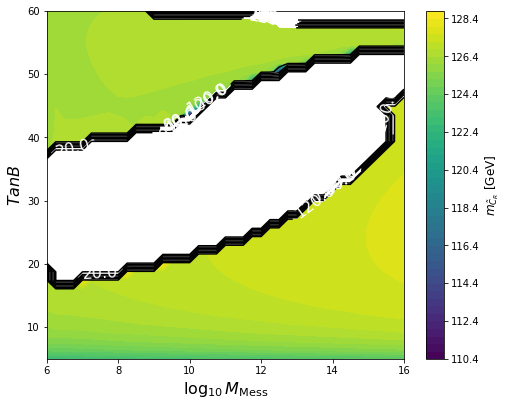

In [64]:
file = resultsb2mMessVstanB
plotData = []
for i in gridtabB:
    row = []
    for j in gridmMess:
        try:
            row.append(file[(j,i)][1].blocks['MASS'][25])
        except:
            row.append(0)
    plotData.append(row)
plotData = np.array(plotData)
fig, ax = plt.subplots( figsize=(8, 6.4))

Zm = np.ma.masked_where(plotData < 1.2, plotData)
#Zm = np.array(plotData)
im = ax.contourf(np.log10(gridmMess), gridtabB, Zm,50)

plt.xlabel(r'$\log_{10}\, M_{\rm{Mess}}$',fontsize=16)
plt.ylabel(r'$TanB$',fontsize=16)
cbar = fig.colorbar(im)
cbar.set_label(r'$m_{\tilde C_{R}}$ [GeV]', size=12)
cs = ax.contour(np.log10(gridmMess), np.array(gridtabB), np.array(Zm),colors='k')
ax.clabel(cs, fontsize=16, inline=1, colors='w',fmt="%1.1f")


In [27]:
print(gridtabB)

[ 5.     5.875  6.75   7.625  8.5    9.375 10.25  11.125 12.    12.875
 13.75  14.625 15.5   16.375 17.25  18.125 19.    19.875 20.75  21.625
 22.5   23.375 24.25  25.125 26.    26.875 27.75  28.625 29.5   30.375
 31.25  32.125 33.    33.875 34.75  35.625 36.5   37.375 38.25  39.125
 40.   ]


In [46]:
print(np.array(Zm))

[['123.039249' '123.043508' '123.053107' ... '123.968631' '123.990132'
  '124.011569']
 ['124.109124' '124.131031' '124.138646' ... '125.043516' '125.065225'
  '125.086894']
 ['124.809496' '124.843367' '124.84957' ... '125.744732' '125.76654'
  '125.788307']
 ...
 ['126.28655' 'No Solution' 'No Solution' ... '127.476069' '127.501046'
  '127.523982']
 ['126.245403' '126.497352' '126.479319' ... 'No Solution' '127.479685'
  '127.503845']
 ['126.20684' '126.474657' '126.456306' ... 'No Solution' '127.455944'
  '127.481923']]


In [38]:
print(gridmMess)

[1.00000000e+06 1.77827941e+06 3.16227766e+06 5.62341325e+06
 1.00000000e+07 1.77827941e+07 3.16227766e+07 5.62341325e+07
 1.00000000e+08 1.77827941e+08 3.16227766e+08 5.62341325e+08
 1.00000000e+09 1.77827941e+09 3.16227766e+09 5.62341325e+09
 1.00000000e+10 1.77827941e+10 3.16227766e+10 5.62341325e+10
 1.00000000e+11 1.77827941e+11 3.16227766e+11 5.62341325e+11
 1.00000000e+12 1.77827941e+12 3.16227766e+12 5.62341325e+12
 1.00000000e+13 1.77827941e+13 3.16227766e+13 5.62341325e+13
 1.00000000e+14 1.77827941e+14 3.16227766e+14 5.62341325e+14
 1.00000000e+15 1.77827941e+15 3.16227766e+15 5.62341325e+15
 1.00000000e+16]


In [66]:
plt.savefig('b2mMessVsTanb2')

<Figure size 432x288 with 0 Axes>